This notebook contains a simulation and code for testing and developing a VAE for fitting models across multiple subjects

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib qt # For some reason, this can slow things down

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

## Define helper functions here

In [4]:
def gen_couplings(neuron_ctrs, mode_ctr, mode_pos_std, mode_ctr_mean, mode_noise_std):
    """ Generates ground truth couplings. """
    weighted_distance_from_ctrs = np.sum(((neuron_ctrs - mode_ctr)/mode_pos_std)**2, axis=1)
    coupling_means = mode_ctr_mean*np.exp(-1*weighted_distance_from_ctrs)
    return np.random.randn(len(coupling_means))*mode_noise_std + coupling_means 

In [5]:
def visualize_couplings(neuron_ctrs, p_couplings, u_couplings, max_mag=1):
    """ Generates plots of couplings. """
    n_neurons = neuron_ctrs.shape[0]
    n_modes = p_couplings.shape[1]
    
    cmap = matplotlib.cm.get_cmap('PiYG')
    
    for m_i in range(n_modes):
        a = plt.subplot(n_modes, 2, 2*m_i + 1)
        for n_i in range(n_neurons):
            c_vl = p_couplings[n_i, m_i]/(2*max_mag) + .5
            clr = cmap(c_vl)
            p = plt.plot(neuron_ctrs[n_i,0], neuron_ctrs[n_i,1], 'ko', 
                        alpha=.5, markerfacecolor=clr)
        a.set_xticklabels([])
        a.set_yticklabels([])
        if m_i == 0:
            plt.title('P Couplings')
        
        a = plt.subplot(n_modes, 2, 2*m_i + 2)
        for n_i in range(n_neurons):
            c_vl = u_couplings[n_i, m_i]/(2*max_mag) + .5
            clr = cmap(c_vl)
            p = plt.plot(neuron_ctrs[n_i,0], neuron_ctrs[n_i,1], 'ko', 
                         alpha=.5, markerfacecolor=clr)
        a.set_xticklabels([])
        a.set_yticklabels([])
        if m_i == 0:
            plt.title('U Couplings')

## Parameters go here

In [6]:
n_neurons_per_subject = [90, 100, 110, 80, 102] # Length implicitly defines # of subjects

n_smps_per_subject = [1000, 1100, 900, 999, 1230] # Number of (x,y) pairs for each subject

# We model distributions of couplings with bumps - where the magnitude of a coupling is a 
# function of how far that neuron is from the center of the bump + some noise 

# Here we specify the centers where couplings are heighest for each p mode
p_mode_centers = np.asarray([[.2, .2], [.5, .5], [.8, .8]]) 
# Here we specify the standard deviation of the spatial extents of couplings for each p mode
p_mode_pos_stds = np.asarray([[.3, .3], [.3, .3], [.3, .3]]) 
# Here we define the mean value for a coupling at the center of each mode
p_mode_mean_center_coupling = [1, 1, 1]
# Here we define how much noise to add when generating couplings for each mode
p_mode_noise_stds = [.000005, .000005, .000005]

# Parmeters for generate u mode couplings 
u_mode_centers = np.asarray([[.2, .2], [.5, .5], [.8, .8]]) # Physical centers of u modes
u_mode_stds = np.asarray([[.4, .4], [.4, .4], [.4, .4]])
u_mode_mean_center_coupling = [1, -1, 1]
u_mode_noise_stds = [.000005, .000005, .000005]

# Range to generate neuron private noise variances from, for each subject
priv_noise_var_ranges = np.asarray([[.5, .8],
                                    [.5, .8],
                                    [.5, .8],
                                    [.5, .8],
                                    [.5, .8]])

## Generate each ground truth model and data

In [7]:
n_subjects = len(n_neurons_per_subject)
n_modes = p_mode_centers.shape[0]
subjects = [None]*n_subjects
for s_i in range(n_subjects):
    n_neurons = n_neurons_per_subject[s_i]
    n_smps = n_smps_per_subject[s_i]
    
    # Generate neuron locations uniformly in the unit square
    neuron_x = np.random.rand(n_neurons)
    neuron_y = np.random.rand(n_neurons)
    neuron_ctrs = np.stack([neuron_x, neuron_y]).transpose()
    
    # Generate couplings 
    p = np.zeros([n_neurons, n_modes])
    u = np.zeros([n_neurons, n_modes])
    for m_i in range(n_modes):
        p[:, m_i] = gen_couplings(neuron_ctrs, p_mode_centers[m_i,:], p_mode_pos_stds[m_i,:], 
                          p_mode_mean_center_coupling[m_i], p_mode_noise_stds[m_i])
        u[:, m_i] = gen_couplings(neuron_ctrs, u_mode_centers[m_i,:], u_mode_stds[m_i,:], 
                          u_mode_mean_center_coupling[m_i], u_mode_noise_stds[m_i])
        
    # Generate x smps - these just come from a standard normal 
    x = np.random.randn(n_smps, n_neurons)
    
    # Generate means for each y smp
    l = np.matmul(x, p)
    y_mn = np.matmul(l, u.transpose())
    
    # Generate private noise variances
    priv_var_width = priv_noise_var_ranges[s_i,1] - priv_noise_var_ranges[s_i,0]
    priv_var = np.random.rand(n_neurons)*priv_var_width + priv_noise_var_ranges[s_i,0]
    
    # Generate y smps
    y_noise = np.random.randn(n_smps, n_neurons)*priv_var
    y = y_mn + y_noise
    
    # Store results
    s_dict = dict()
    s_dict['n_neurons'] = n_neurons
    s_dict['n_smps'] = n_smps
    s_dict['neuron_ctrs'] = neuron_ctrs
    s_dict['p'] = p
    s_dict['u'] = u
    s_dict['priv_var'] = priv_var
    s_dict['x'] = x
    s_dict['y'] = y
    s_dict['y_mn'] = y_mn
    s_dict['p_mode_centers'] = p_mode_centers
    s_dict['u_mode_centers'] = u_mode_centers
    s_dict['p_mode_pos_stds'] = p_mode_pos_stds
    s_dict['u_mode_pos_stds'] = p_mode_pos_stds
    s_dict['p_mode_noise_stds'] = np.asarray(u_mode_noise_stds)
    s_dict['u_mode_noise_stds'] = np.asarray(u_mode_noise_stds)
    s_dict['p_mode_mean_center_coupling'] = np.asarray(p_mode_mean_center_coupling)
    s_dict['u_mode_mean_center_coupling'] = np.asarray(u_mode_mean_center_coupling)
    
    subjects[s_i] = s_dict

## Look at ground truth data for one subject

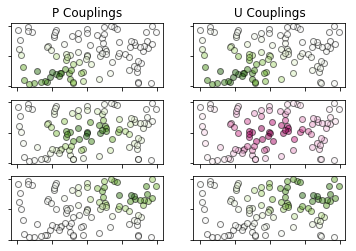

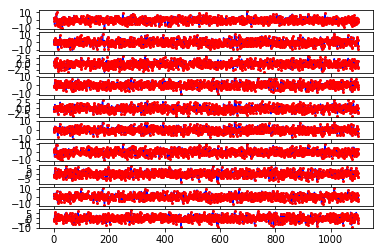

In [8]:
vis_subj = 1 # The subject we want to visualize ground truth for
subject = subjects[vis_subj]


# Visualize couplings
plt.figure()
visualize_couplings(subject['neuron_ctrs'], 
                    subject['p'], 
                    subject['u'])

# Visualize y data
roi_inds = np.arange(0, subject['n_neurons'], 10)
plt.figure()
for i, roi_i in enumerate(roi_inds):
    plt.subplot(len(roi_inds), 1, i+1)
    plt.plot(subject['y_mn'][:, roi_i], 'b-')
    plt.plot(subject['y'][:, roi_i], 'ro', markersize=2)

## Define VAE Objects

In [9]:
class MultiNeuronCouplingVariationalDistribution(torch.nn.Module):
    """ Variational distribution for the p or u modes of all neurons"""
    def __init__(self, mode_shape):
        super().__init__()
        
        self.mn = torch.nn.Parameter(torch.zeros(mode_shape), requires_grad=True)
        torch.nn.init.xavier_normal_(self.mn)
        
        self.log_std = torch.nn.Parameter(torch.zeros(mode_shape), requires_grad=True)
        torch.nn.init.xavier_normal_(self.log_std)
        
    def forward(self, x: torch.Tensor):
        """ Currently don't use x. """
        return self.mn
    
    def mean(self):
        return self.mn
    
    def std(self):
        return torch.exp(self.log_std) # Could also think about trying a Relu
    
    def sample_given_z(self, z: torch.Tensor):
        return self.mn + self.std()*z

In [10]:
class ConditionalCouplingsDistrbution(torch.nn.Module):
    """ Distribution of couplings for either p or u given measurable properties for one neuron.
    """
    
    def __init__(self, n_modes: int, n_properties: int):
        
        super().__init__()
        
        self.n_modes = n_modes
        self.n_properties = n_properties
        
        self.centers = torch.nn.Parameter(torch.zeros([n_modes, n_properties]), requires_grad=True)
        torch.nn.init.uniform_(self.centers, 0, 1)
        
        self.log_prop_stds = torch.nn.Parameter(torch.zeros([n_modes,n_properties]), requires_grad=True)
        torch.nn.init.normal_(self.log_prop_stds)
        
        self.gains = torch.nn.Parameter(torch.zeros(n_modes), requires_grad=True)
        torch.nn.init.normal_(self.gains)
        
        self.log_noise_stds = torch.nn.Parameter(torch.zeros(n_modes), requires_grad=True)
        torch.nn.init.normal_(self.log_noise_stds)
    
    def forward(self, properties: torch.Tensor):
        """ Computes means given properties for a set of neurons. 
        
        Args:
            properties: Of shape n_neurons*n_properties
        """
        
        prop_stds = torch.exp(self.log_prop_stds)
        
        properties_view =  properties.unsqueeze(1).repeat([1, self.n_modes, 1])
        properties_weighted_delta = properties_view - self.centers
        properties_distance = torch.sum((properties_weighted_delta/prop_stds)**2, dim=2)
        
        mns = torch.exp(-1*properties_distance)*self.gains
        
        return mns
    
    def cond_mean(self, properties: torch.Tensor):
        return self(properties)
    
    def cond_std(self, properties: torch.Tensor):
        """ Currently std is invariant to properties. """
        
        n_neurons = properties.shape[0]
        
        noise_std =  torch.exp(self.log_noise_stds)
        return noise_std.unsqueeze(0).repeat(n_neurons, 1)

In [11]:
class ConditionalYDistribution(torch.nn.Module):
    """ Conditional distribution for y|x, p, u for a particular subject. 
    """
    
    def __init__(self, n_neurons: int):
        
        super().__init__()
         
        self.log_std = torch.nn.Parameter(torch.zeros(n_neurons), requires_grad=True)
        torch.nn.init.normal_(self.log_std)
        
    def forward(self, x: torch.Tensor, p: torch.Tensor, u: torch.Tensor):
        """ Computes conditional mean.
        
        Args:
            x: input of shape n_smps * n_neurons
            
            p: modes which project to latents of shape n_neurons * n_modes
            
            u: modes which project back to mean firing rates, of shape n_neurons * n_modes
        """
        l = torch.matmul(x, p)
        mns = torch.matmul(l, u.t())
        
        return mns
        
    def cond_neg_ll(self, x: torch.Tensor, y: torch.Tensor, p: torch.Tensor, u: torch.Tensor):
        n_smps = x.shape[0]
        log_2_pi = float(np.log(2*np.pi))

        mn = self(x, p, u)
        
        psi = torch.exp(self.log_std)
        
        neg_ll = .5*mn.nelement()*log_2_pi
        neg_ll += n_smps*torch.sum(self.log_std) # don't need .5 here b/c we are taking log of std^2
        neg_ll += .5*torch.sum(((y - mn)/psi)**2)
        
        return neg_ll

## Define object we will use for calculating KL divergence 

(This is just a convenience object, giving us some modularity so we can easily use the code below for working with more complicated distributions.)

In [16]:
class ProdKLDivergence():
    """ For calculating KL divergence between two Normal distributions with diagonal covariances.

    In particular, this will calculate the KL divergence between two conditional distributions
    given input. 

    """
    
    def __init__(self, d1: torch.nn.Module, d2: torch.nn.Module):
        """ Creates a ProdKLDivergence object
        
        Args:
            d1: Module representing a conditional multivariate normal distribution.  Must have 
            the methods 'mean' which returns the mean of a distribution given some input and 
            'std' which returns the square root of the diagonal of the covariance matrix given
            some input.  The returned mean and standard deviations can be shaped as general 
            tensors (i.e., they don't have to be vectorized.)
            
            d2: Same as d1, but for the second distribution
        """
        
        self.d1 = d1
        self.d2 = d2
    
    def kl(x: torch.Tensor):
        """ Computes the KL divergence between two conidtion distributions given input.
        
        Args:
            x: input we condition on, of shape n_smps * n_neurons
        """
        pass